In [2]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import numpy as np
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator


In [78]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000,)
np.set_printoptions(suppress=True)

In [87]:

from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.structures.synapses import NeuralMass, NeuralWeights


def calculate_gc2pc_weights(gc_fr_maps, res, n_mod, n_per_mod, n_pc_mod, x_max, y_max):
    n_GCs = n_mod * n_per_mod
    n_PCs = n_pc_mod**2
    gc2pc_weights = np.zeros((n_PCs, n_GCs))
    shape = gc_fr_maps.shape
    PCtmplte = np.zeros(shape)

    for x in np.arange(res, x_max + res, res) * 2:
        for y in np.arange(res, y_max + res, res) * 2:
            PC = PCtmplte.copy()
            PC[int(x), int(y)] = 1
            for i in range(n_mod):
                for j in range(n_per_mod):
                    # fire_map = np.max(np.multiply(PC, np.expand_dims(gc_fr_maps[:, :, j, i], (2, 3))))
                    fr_maps = gc_fr_maps[:, :, j, i][:, :, np.newaxis, np.newaxis]
                    print(PC.shape, fr_maps.shape, np.repeat(fr_maps, [1, PC.shape[-1]] ).shape)#, np.repeat(fr_maps, [1, 1, PC.shape[1], PC.shape[2]] ).shape)
                    # fire_map = np.max(np.multiply(PC, gc_fr_maps[:, :, j, i][:, :, np.newaxis, np.newaxis]))
                    fire_map = np.max(np.multiply(PC, np.repeat(gc_fr_maps[:, :, j, i][:, :, np.newaxis, np.newaxis], [1, 1, PC.shape[1], PC.shape[2]] )))
                    gc2pc_weights[int((x - 1) * n_pc_mod + y), int((i - 1) * n_per_mod + j)] = fire_map

    return gc2pc_weights


class PCGenerator(AbstractGenerator):
    """
    A class for calculating place cell weight matrices based on grid cell firing rate maps and specified parameters.
    """
    def __init__(
        self,
        res: float,
        x_max: int,
        y_max: int,
        n_mod: int,
        n_per_mod: int,
        gc_map: GCMap
    ):
        """
        Initializes the PCGenerator.

        Args:
            res (float): Resolution for calculating place cell weight matrices.
            x_max (int): Maximum value along the x-axis.
            y_max (int): Maximum value along the y-axis.
            n_mod (int): Number of modules.
            n_per_mod (int): Number of cells per module.
            gc_map (GCMap): Instance of GCMap containing grid cell firing rate maps.
        """
        self.gc_map = gc_map

        self.res = res
        self.x_max = x_max
        self.y_max = y_max
        self.n_mod = n_mod
        self.n_per_mod = n_per_mod
        self.n_points_x = int(self.x_max / self.res)
        self.n_points_y = int(self.y_max / self.res)
        self.n_gc = self.n_mod * self.n_per_mod
        self.n_pc = self.n_points_x*self.n_points_y

    def generate_gc2pc_weights(self):
        """
        Generates weights from grid cells to place cells.

        Returns:
            np.ndarray: Generated GC to PC weights.
        """
        gc2pc_weights = np.zeros((self.n_pc, self.n_points_x * self.n_points_y))
        shape = self.gc_map.std.shape
        pc_template = np.zeros((shape[0], shape[1]))

        for x in range(self.n_points_x):
            for y in range(self.n_points_y):
                PC = pc_template.copy()
                PC[x, y] = 1

                for i in range(self.n_mod):
                    for j in range(self.n_per_mod):
                        gc2pc_weights[x * self.n_points_x + y, i * self.n_per_mod + j] = np.max(PC * self.gc_map.std[:, :, j, i])

        return gc2pc_weights


    def generate(self) -> np.ndarray:
        """
        Generate place cell weight matrix based on grid cell firing rate maps.

        Args:
            save (bool, optional): Whether to save the generated weight matrix. Defaults to False.

        Returns:
            np.ndarray: Generated place cell weight matrix.
        """
        gc2pc_weights = self.generate_gc2pc_weights()

        return NeuralMass(
            NeuralWeights(
                from_='gc',
                to='pc',
                weights=gc2pc_weights
            )
        )

In [91]:
generator = PCGenerator(
    res=0.5,
    x_max=22,
    y_max=22,
    n_mod=7,
    n_per_mod=100,
    gc_map=GCMap.load('../data/grid_cells/gc_map.pkl')
)

In [92]:
gc2pc_weights = generator.generate()

In [72]:
from bbtoolkit.preprocessing.neural_generators import GCMap


gc_fr_maps = GCMap.load('../data/grid_cells/gc_map.pkl').std
res = 0.5
n_mod = 7
n_per_mod = 100
n_GCs = n_mod * n_per_mod
x_max = 22
y_max = 22
n_points_x = int(x_max / res)
n_points_y = int(y_max / res)
n_PCs = n_points_x*n_points_y

In [76]:
GC2PCwts = np.zeros((n_PCs, n_GCs))
shape = gc_fr_maps.shape
PCtmplte = np.zeros((shape[0], shape[1]))
import time
start = time.time()
for x in range(n_points_x):
    for y in range(n_points_y):
        PC = PCtmplte.copy()
        PC[x, y] = 1
        for i in range(n_mod):
            for j in range(n_per_mod):
                GC2PCwts[
                    x*n_points_x + y,
                    i*n_per_mod + j
                ] = np.max(
                    PC*gc_fr_maps[:, :, j, i]
                )
end = time.time()
duration = end - start
print(duration)

21.862199544906616


In [ ]:

def generate_GC_to_PC_weights(gc_fr_maps, n_points_x, n_points_y, n_mod, n_per_mod):
    n_PCs = n_mod * n_per_mod
    GC2PCwts = np.zeros((n_PCs, n_points_x * n_points_y))
    shape = gc_fr_maps.shape
    PCtmplte = np.zeros((shape[0], shape[1]))

    start = time.time()

    for x in range(n_points_x):
        for y in range(n_points_y):
            PC = PCtmplte.copy()
            PC[x, y] = 1

            for i in range(n_mod):
                for j in range(n_per_mod):
                    GC2PCwts[x * n_points_x + y, i * n_per_mod + j] = np.max(PC * gc_fr_maps[:, :, j, i])

    return GC2PCwts

In [63]:
PC = PCtmplte.copy()
PC[0, 0] = 1
np.max(
    PC*gc_fr_maps[:, :, 1, 0]
)

0.8763554448517495

In [38]:
GC2PCwts.shape

(1936, 700)

In [93]:
gc2pc_weights.gc.to.pc[:11, 179:186]

array([[0.        , 0.5305871 , 0.60719924, 0.48235235, 0.2039308 , 0.        , 0.        ],
       [0.        , 0.4403809 , 0.511484  , 0.39565121, 0.13731142, 0.        , 0.        ],
       [0.        , 0.34620454, 0.41124899, 0.30532606, 0.0690656 , 0.        , 0.        ],
       [0.        , 0.25014236, 0.30862488, 0.21343081, 0.0089671 , 0.        , 0.        ],
       [0.        , 0.15426883, 0.2057364 , 0.12200712, 0.        , 0.        , 0.        ],
       [0.        , 0.06059145, 0.1046448 , 0.03323315, 0.        , 0.        , 0.        ],
       [0.        , 0.00038139, 0.01343719, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.

In [86]:
GC2PCwts[:11, 179:186]

array([[0.        , 0.5305871 , 0.60719924, 0.48235235, 0.2039308 , 0.        , 0.        ],
       [0.        , 0.4403809 , 0.511484  , 0.39565121, 0.13731142, 0.        , 0.        ],
       [0.        , 0.34620454, 0.41124899, 0.30532606, 0.0690656 , 0.        , 0.        ],
       [0.        , 0.25014236, 0.30862488, 0.21343081, 0.0089671 , 0.        , 0.        ],
       [0.        , 0.15426883, 0.2057364 , 0.12200712, 0.        , 0.        , 0.        ],
       [0.        , 0.06059145, 0.1046448 , 0.03323315, 0.        , 0.        , 0.        ],
       [0.        , 0.00038139, 0.01343719, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.

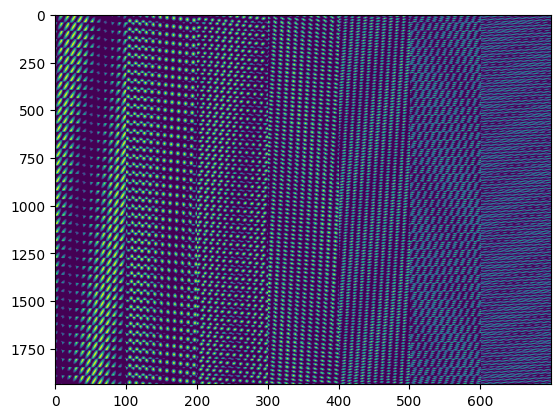

In [83]:
from matplotlib import pyplot as plt


plt.imshow(GC2PCwts, aspect='auto')